<a href="https://colab.research.google.com/github/cweyandt/orb/blob/main/01%20Data%20Ingestion/data_processing_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset loading and processing into dataframes
  

2021-05-18 CWeyandt  
- Each cell processes a single set of raw data files stored in the shared google drive under `/content/drive/Shareddrives/Capstone_Vacancy/data/`

- Each time this notebook is run, it is necessary to re-authenticate the notebook to allow access to google drive. Note that this is allowing access to your *entire* google drive, not just the specified folder.

In [ ]:
# !pip install ipympl

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import re
import altair as alt 

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
#import datetime
# %matplotlib widget

In [ ]:
# Mount google drive to list the raw data files

# Mounting the drive is straightforward but requires authentication each 
# time we reset the session
drive.mount('/content/drive')
drive_path = '/content/drive/Shareddrives/Capstone_Vacancy/data/'
! ls /content/drive/Shareddrives/Capstone_Vacancy/data

Mounted at /content/drive
cleaned			meterWaterFlow.csv	 securityUniqueHourly.csv
co2Sensor.csv		occSensors		 soundLevelSensor.csv
freezers		occSensorZone.csv	 tvocSensor.csv
fumehoodFlow.csv	securityCardEvents.csv	 wifi_ap_data.csv
lighting.csv		securityDaily.csv
lightingOccSensors.csv	securityUniqueDaily.csv


# Wifi AP connected devices

In [ ]:
# Load the dataframe from csv file
wifi_ap_data = pd.read_csv(drive_path + 'wifi_ap_data.csv', index_col=0)
wifi_ap_data.head()

# Process timestamp (check timezone!)
wifi_ap_data.index = pd.DatetimeIndex(pd.to_datetime(wifi_ap_data.index, utc=True).tz_convert("US/Pacific"))

# Rename exterior access points
wifi_ap_data.rename(columns={'balcony': '300_Ext', 
                             'entrance-ne': '384_Ext','entrance-sw': '361_Ext',
                             'terrace-e':'201_Ext','terrace-w':'283_Ext'}, 
                    inplace=True)

# Add floor and int,ext indexes
wifi_ix_floors = wifi_ap_data.columns.str.extract(r'(^.{1})')
wifi_ix_rooms = wifi_ap_data.columns.str.extract(r'(^\w{3}[a-d|f-m]?)')
wifi_ix_ext = wifi_ap_data.columns.str.extract(r'_(Ext)').notna()
arrays = [
          wifi_ix_ext.to_numpy().transpose()[0],
          wifi_ix_floors.to_numpy().transpose()[0],
          wifi_ix_rooms.to_numpy().transpose()[0],
          wifi_ap_data.columns.to_numpy()
]
wifiData = wifi_ap_data.copy() 
wifiData.columns = pd.MultiIndex.from_arrays(arrays, names=['External','Floor','Room','AP'])
wifiData.index.name = 'ts'
# wifiData.to_csv(drive_path + 'cleaned/' + 'wifi_ap_data.csv')
wifiData.to_pickle(drive_path + 'cleaned/' + 'wifi_ap_data.pkl')

Text(0, 0.5, 'Number of devices connected (count)')

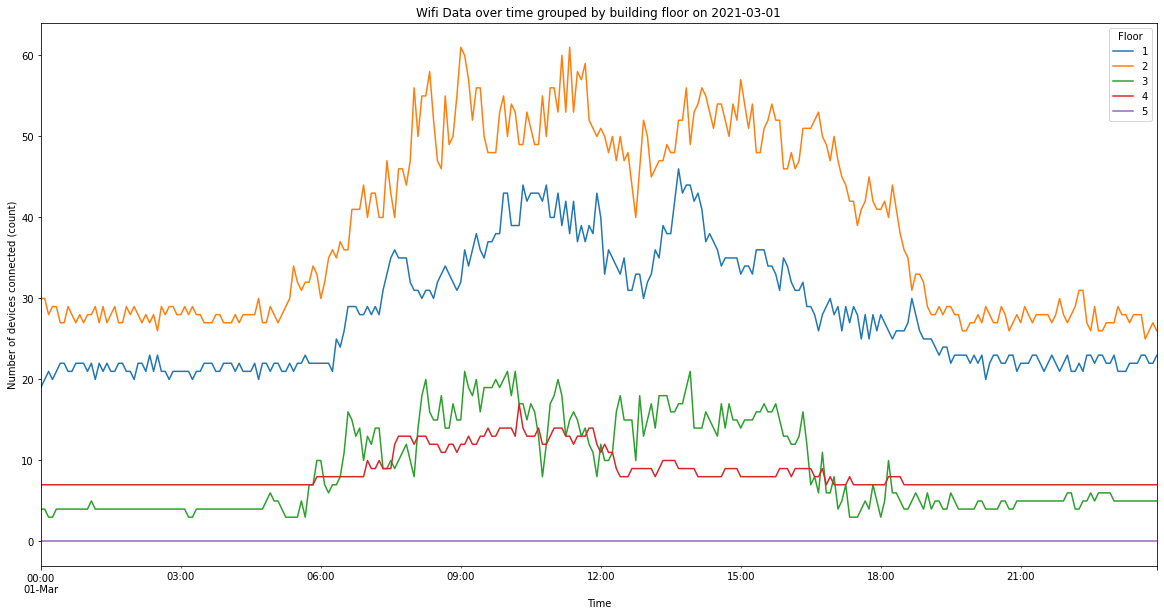

In [ ]:
wifiData.tail()
wifiData["2021-03-01"].groupby('Floor', axis=1).sum().plot(stacked=False)
# wifiData["2021-01"].groupby('Floor', axis=1).sum().diff().plot()
plt.title('Wifi Data over time grouped by building floor on 2021-03-01')
plt.xlabel('Time')
plt.ylabel('Number of devices connected (count)')

# CO2 sensors

In [ ]:
# Read CSV
co2Sensor_data = pd.read_csv(drive_path + 'co2Sensor.csv', index_col=0).dropna(how='all')

# Reindex manually, with Room/Floor columns
co2Sensor_data.columns = pd.MultiIndex.from_arrays([['2','1','3','4'],
                                                    ['244','125','384','481']],
                                                   names=['Floor','Room'])
co2Sensor_data.index.name = 'ts'

# Process timestamp
co2Sensor_data.index = pd.DatetimeIndex(pd.to_datetime(co2Sensor_data.index, utc=True, format="%Y-%m-%dT%H:%M:%S%z Los_Angeles").tz_convert("US/Pacific"))

# co2Sensor_data.to_csv(drive_path + 'cleaned/' + 'co2Sensors.csv')
co2Sensor_data.to_pickle(drive_path + 'cleaned/' + 'co2Sensors.pkl')

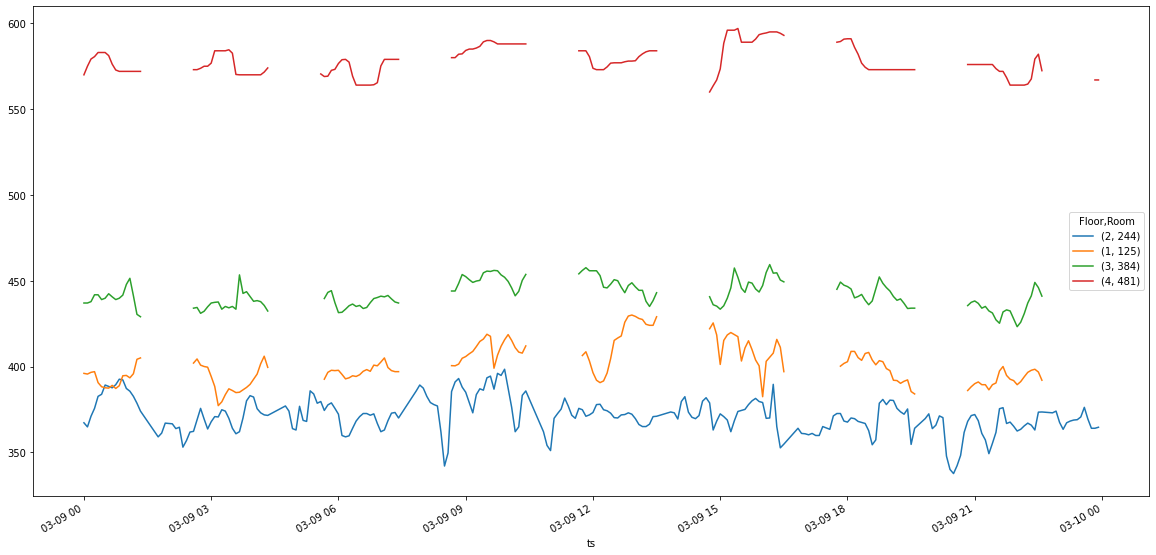

In [ ]:
#co2Sensor_data = co2Sensor_data.dropna(axis=0, how='all')
co2Sensor_data.tail() #plot(legend=False)
co2Sensor_data['2021-03-09'].plot(legend=True)

# Sound level sensors

In [ ]:
soundLevelSensor_data = pd.read_csv(drive_path + 'soundLevelSensor.csv', index_col=0).dropna(how='all')

# TODO: Process Timestamp
soundLevelSensor_data.index = pd.DatetimeIndex(
    pd.to_datetime(soundLevelSensor_data.index, utc=True, format="%Y-%m-%dT%H:%M:%S%z Los_Angeles").tz_convert("US/Pacific"))
soundLevelSensor_data.index.name = 'ts'

# removed db string and convert to number - done in SublimeText
# TODO: Process NaN... reduce size of df? This data does not span full year
# soundLevelSensor_data.plot(legend=False)

arrays = [
          soundLevelSensor_data.columns.str.extract(r'^Floor (\d)').to_numpy().transpose()[0],
          soundLevelSensor_data.columns.str.extract(r'Rm (\d{3})').to_numpy().transpose()[0],
]

soundLevelSensor_data.columns = pd.MultiIndex.from_arrays(arrays, names=['Floor','Room'])

# soundLevelSensor_data.to_csv(drive_path + 'cleaned/' + 'soundLevelSensor.csv')
soundLevelSensor_data.to_pickle(drive_path + 'cleaned/' + 'soundLevelSensor.pkl')

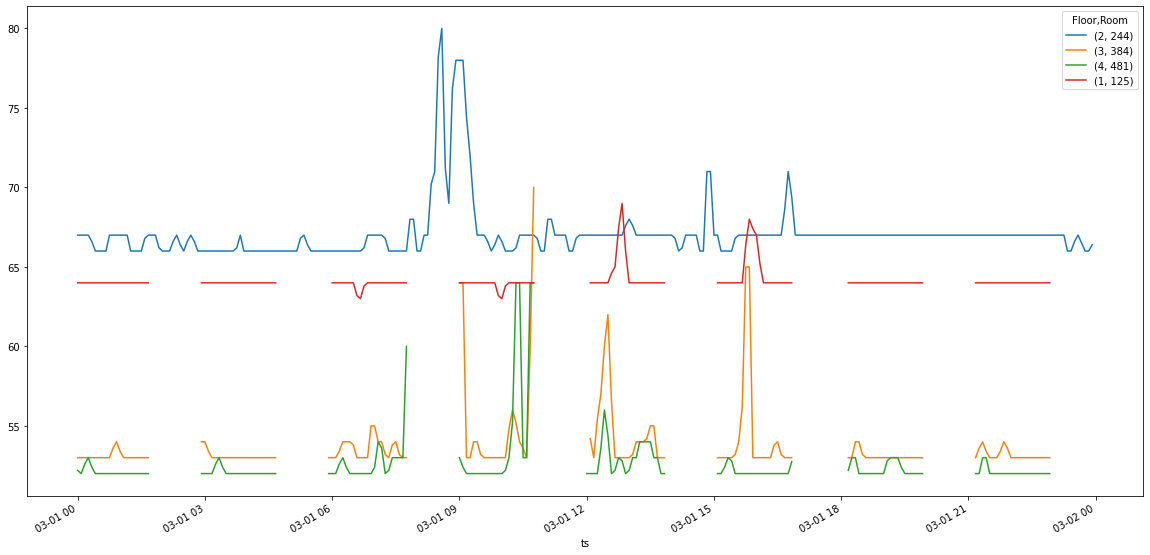

In [ ]:

soundLevelSensor_data.head()

soundLevel = soundLevelSensor_data['2021-01-18':]

soundLevel['2021-03-01'].plot()

# TVOC sensors

In [ ]:
tvocSensor_data = pd.read_csv(drive_path + 'tvocSensor.csv', index_col=0)
tvocSensor_data.tail()

# Process Timestamp
tvocSensor_data.index = pd.DatetimeIndex(
    pd.to_datetime(tvocSensor_data.index, utc=True, format="%Y-%m-%dT%H:%M:%S%z Los_Angeles").tz_convert("US/Pacific"))
tvocSensor_data.tail()

arrays = [
          tvocSensor_data.columns.str.extract(r'^Floor (\d)').to_numpy().transpose()[0],
          tvocSensor_data.columns.str.extract(r'Rm (\d{3})').to_numpy().transpose()[0],
]

tvocSensor_data.columns = pd.MultiIndex.from_arrays(arrays, names=['Floor','Room'])

# tvocSensor_data.to_csv(drive_path + 'cleaned/' + 'tvocSensors.csv')
tvocSensor_data.to_pickle(drive_path + 'cleaned/' + 'tvocSensors.pkl')

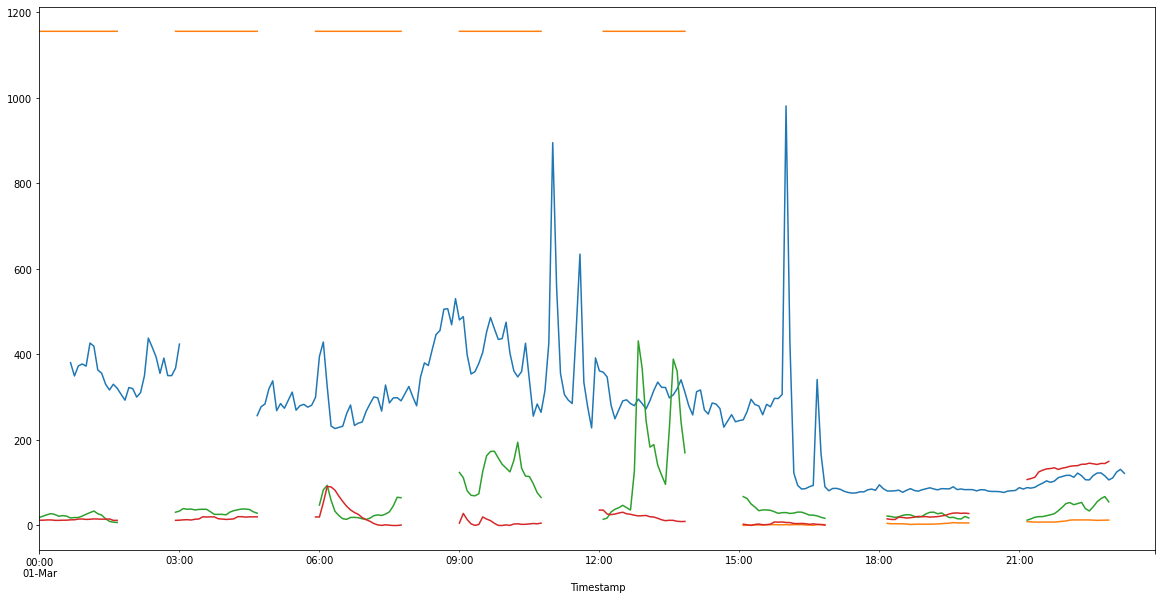

In [ ]:
tvocSensor_data['2021-03-01'].plot(legend=False)


# Fumehood flow rates

In [ ]:
fumehoodFlow_data = pd.read_csv(drive_path + 'fumehoodFlow.csv', index_col=0)

# Process ts column, set as index
fumehoodFlow_data.index = pd.DatetimeIndex(
    pd.to_datetime(fumehoodFlow_data.index, utc=True, format="%Y-%m-%dT%H:%M:%S%z Los_Angeles").tz_convert("US/Pacific"))

# Remove NaN rows (every other row)
fumehoodFlow_data = fumehoodFlow_data.dropna(how='all')

arrays = [
          fumehoodFlow_data.columns.str.extract(r'^Floor (\d)').to_numpy().transpose()[0],
          fumehoodFlow_data.columns.str.extract(r'Rm (\d{3})').to_numpy().transpose()[0],
          fumehoodFlow_data.columns.str.extract(r'\((\d{2})\)').to_numpy().transpose()[0],
]

fumehoodFlow_data.columns = pd.MultiIndex.from_arrays(arrays, names=['Floor','Room','Fumehood'])

# fumehoodFlow_data.to_csv(drive_path + 'cleaned/' + 'fumehoodFlow.csv')
fumehoodFlow_data.to_pickle(drive_path + 'cleaned/' + 'fumehoodFlow.pkl')

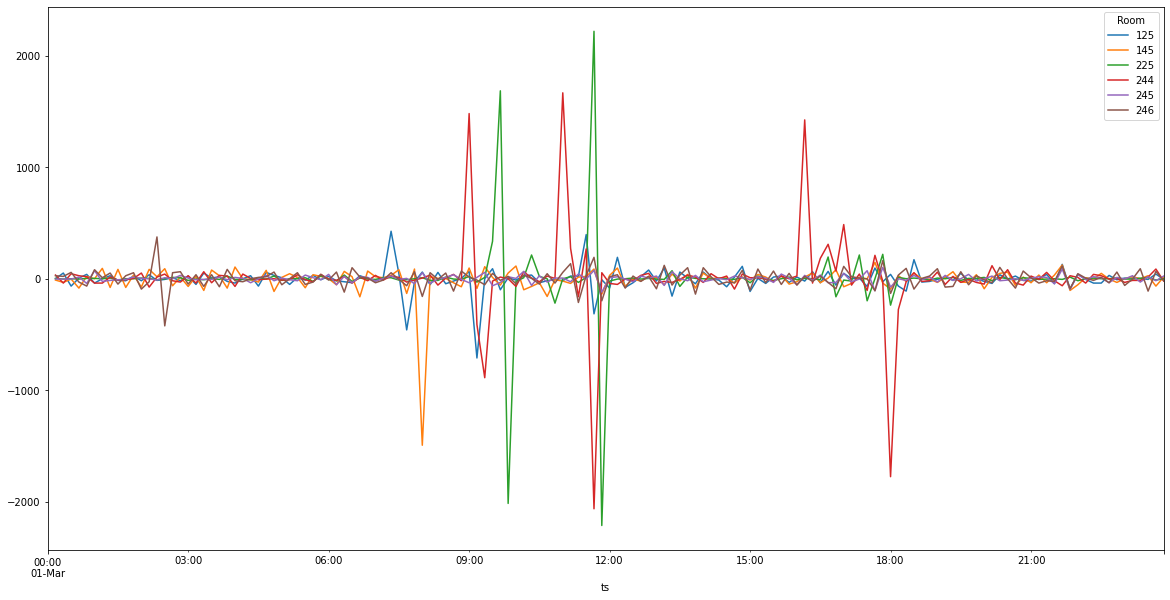

In [ ]:

fumehoodFlow_data.head()

fumehoodFlow_data['2021-03-01'].groupby("Room", axis=1).sum().diff().plot()

# Water meter consumption


In [ ]:
meterWaterFlow_data = pd.read_csv(drive_path + 'meterWaterFlow.csv', index_col=0)
meterWaterFlow_data.tail()

# TODO: Process ts column, apply as index
meterWaterFlow_data.index = pd.DatetimeIndex(
    pd.to_datetime(meterWaterFlow_data.index, utc=True, format="%Y-%m-%dT%H:%M:%S%z Los_Angeles").tz_convert('America/Los_Angeles'))
meterWaterFlow_data.index.name='ts'
meterWaterFlow_data.columns=['Flow']


# remove _pulses string from data, convert to numeric - Done in SublimeText
# Difference data to convert consumption to rate (gallons->gallons-per-minute)
meterWaterFlow = meterWaterFlow_data.diff(periods=1, axis=0)

# Set negative values -> 0 (accomodating for totalizer rollover)
# meterWaterFlow[meterWaterFlow['Flow']<0] = 0
# meterWaterFlow[meterWaterFlow['Flow']>500] = 0

# meterWaterFlow.clip(lower=0, upper=500).to_csv(drive_path + 'cleaned/' + 'waterMeter.csv')
meterWaterFlow.clip(lower=0, upper=500).to_pickle(drive_path + 'cleaned/' + 'waterMeter.pkl')

<Figure size 14400x7200 with 0 Axes>

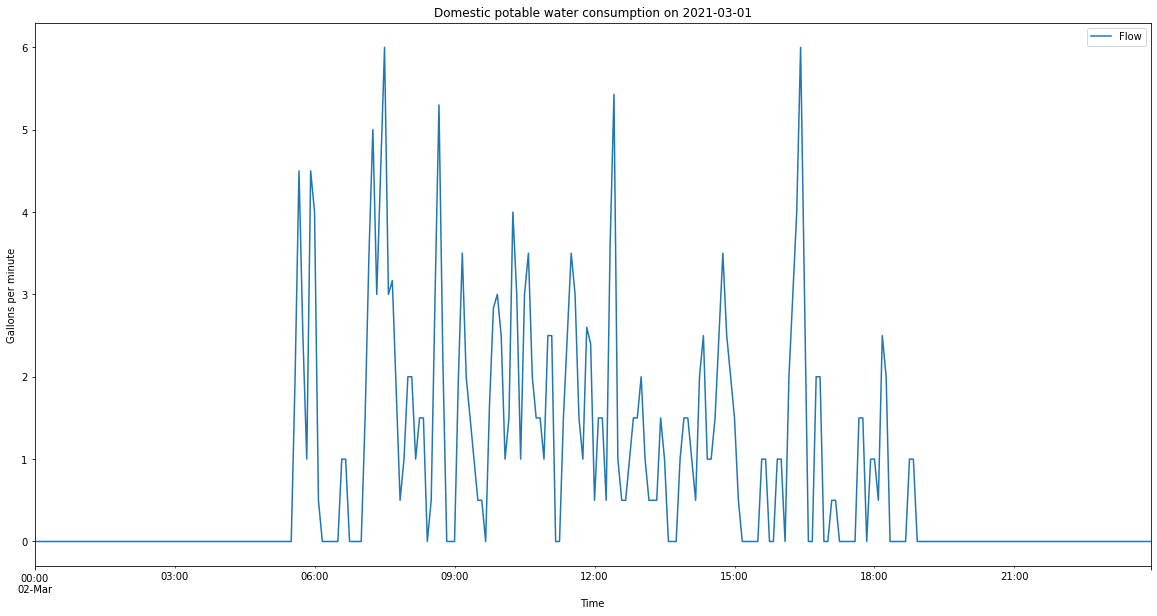

In [ ]:
plt.figure(figsize=(200,100))
meterWaterFlow['2021-03-02'].plot()
plt.title('Domestic potable water consumption on 2021-03-01')
plt.xlabel('Time')
plt.ylabel('Gallons per minute')
plt.show()

# Occupancy sensor - grouped

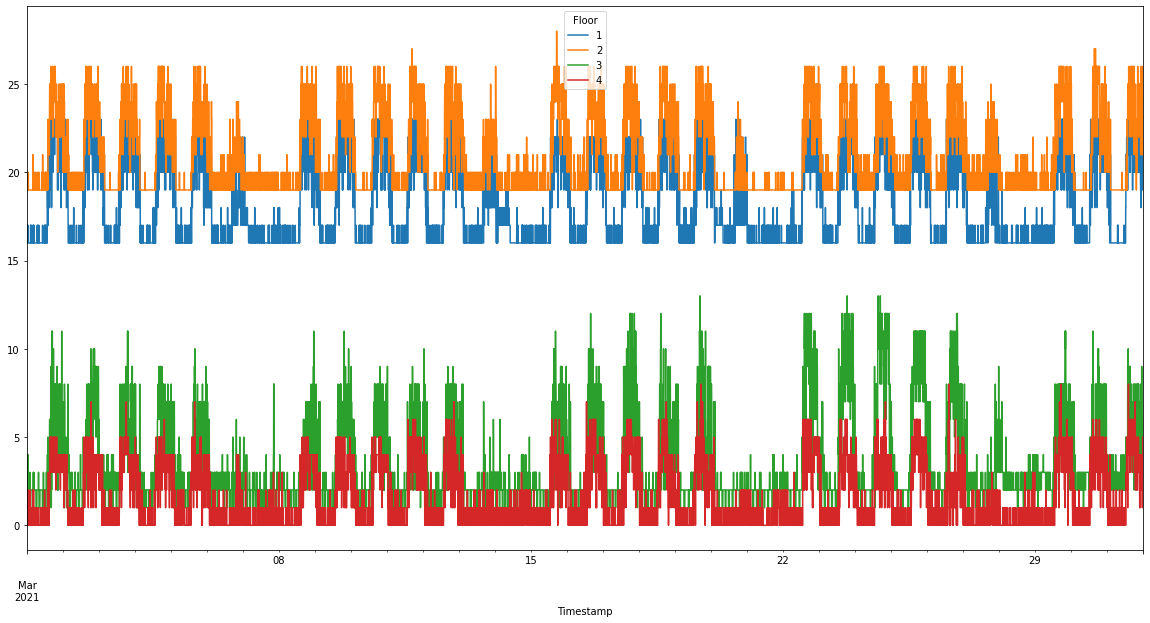

In [ ]:
occSensorZone_data = pd.read_csv(drive_path + 'occSensorZone.csv', index_col=0)
occSensorZone_data.head()

# Process Timestamp
occSensorZone_data.index = pd.DatetimeIndex(
    pd.to_datetime(occSensorZone_data.index, utc=True, format="%Y-%m-%dT%H:%M:%S%z Los_Angeles"))

# Remove timestamps with all NaN
occSensorZone_data = occSensorZone_data.dropna(how='all')

# --- AAAA = inactive
occSensorZone_data.replace(to_replace=re.compile('^AAAA$'), value=False, inplace=True)
# --- AAAB = active
# --- other = activated (multiple changes in this time span) marked same as active
occSensorZone_data.replace(to_replace=re.compile('[^0]'), value=True, inplace=True)

for col in occSensorZone_data.columns:
  occSensorZone_data[col] = occSensorZone_data[col].astype(bool)

# Re-index with Floor / Room / Rooms metadata
arrays = [
          occSensorZone_data.columns.str.extract(r'^Floor (\d)').to_numpy().transpose()[0],
          occSensorZone_data.columns.str.extract(r'Rm (\w{3}[a-d|f-m]?)').to_numpy().transpose()[0],
          occSensorZone_data.columns.str.extract(r'Rm (.*) \w{3,4}-').to_numpy().transpose()[0],
]

occZone = occSensorZone_data.copy()
#occZone = occZone[notna()].astype(int64)
occZone.columns = pd.MultiIndex.from_arrays(arrays, names=['Floor','Room','Rooms'])

occZone.head()
occZone['2021-03'].groupby(by="Floor",axis=1).sum().plot()

# Security card-key

In [ ]:
securityEvents = pd.read_csv(drive_path + 'securityCardEvents.csv', index_col=0).drop(columns=['Date','Time'])
securityEvents.index = pd.DatetimeIndex(
    pd.to_datetime(securityEvents.index, utc=True))
securityEvents['2021-03'].head()
# securityEvents.to_csv(drive_path + 'cleaned/' + 'securityEvents.csv')
securityEvents.to_pickle(drive_path + 'cleaned/' + 'securityEvents.pkl')

In [ ]:
securityDailyAll = pd.read_csv(drive_path + 'securityDaily.csv', index_col=0)
securityDailyAll.index = pd.DatetimeIndex(
    pd.to_datetime(securityDailyAll.index, utc=True))
securityDailyAll['2021-03'].head()
# securityDailyAll.to_csv(drive_path + 'cleaned/' + 'securityDailyAll.csv')
securityDailyAll.to_pickle(drive_path + 'cleaned/' + 'securityDailyAll.pkl')

In [ ]:
securityDailyUnique = pd.read_csv(drive_path + 'securityUniqueDaily.csv', index_col=0)
securityDailyUnique.index = pd.DatetimeIndex(
    pd.to_datetime(securityDailyUnique.index, utc=True))
securityDailyUnique['2021-03'].head()
# securityDailyUnique[['Ext','Int']].plot(stacked=True)
# securityDailyUnique.to_csv(drive_path + 'cleaned/' + 'securityDailyUnique.csv')
securityDailyUnique.to_pickle(drive_path + 'cleaned/' + 'securityDailyUnique.pkl')

In [ ]:
securityHourlyUnique = pd.read_csv(drive_path + 'securityUniqueHourly.csv', index_col=0)
securityHourlyUnique.index = pd.DatetimeIndex(
    pd.to_datetime(securityHourlyUnique.index, utc=True))
securityHourlyUnique['2021-03'].head()
# securityHourlyUnique.to_csv(drive_path + 'cleaned/' + 'securityHourlyUnique.csv')
securityHourlyUnique.to_pickle(drive_path + 'cleaned/' + 'securityHourlyUnique.pkl')

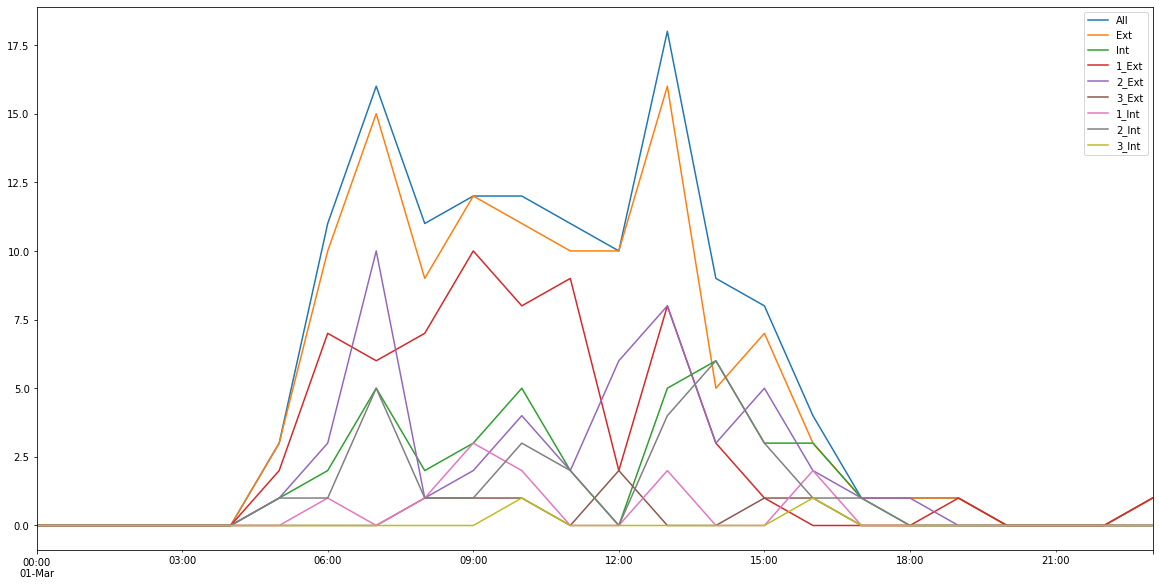

In [ ]:
securityHourlyUnique['2021-03-01'].plot()

# Freezer door data

In [ ]:
# Combine freezer files
frz_df = pd.DataFrame()

for f in os.listdir(drive_path + '/freezers'):
    new_df = pd.read_csv(drive_path + '/freezers/' + f, names=["ts",f[:7]], index_col=0)
    new_df = new_df[new_df[f[:7]] == 1.0]
    new_df.index = pd.DatetimeIndex(
        pd.to_datetime(new_df.index, utc=True).tz_convert("US/Pacific"))
    if frz_df.empty:
        frz_df = new_df
    else:
        frz_df = frz_df.merge(new_df, how='outer', on="ts", sort=True)
  
freezers = frz_df.copy()

In [ ]:
arrays = [
          frz_df.columns.str.extract(r'^0(\d)').to_numpy().transpose()[0],
          frz_df.columns.str.extract(r'^0(\d{3})').to_numpy().transpose()[0],
          frz_df.columns.str.extract(r'-(\d{2,4})').to_numpy().transpose()[0],
]

freezers.columns = pd.MultiIndex.from_arrays(arrays, names=['Floor','Room','Freezer'])

# freezers['2021-03'].groupby(by='Room',axis=1).count().resample('H').sum().plot()

# freezers.to_csv(drive_path + 'cleaned/' + 'freezers.csv')
freezers.to_pickle(drive_path + 'cleaned/' + 'freezers.pkl')

Text(0, 0.5, 'Count of door open events')

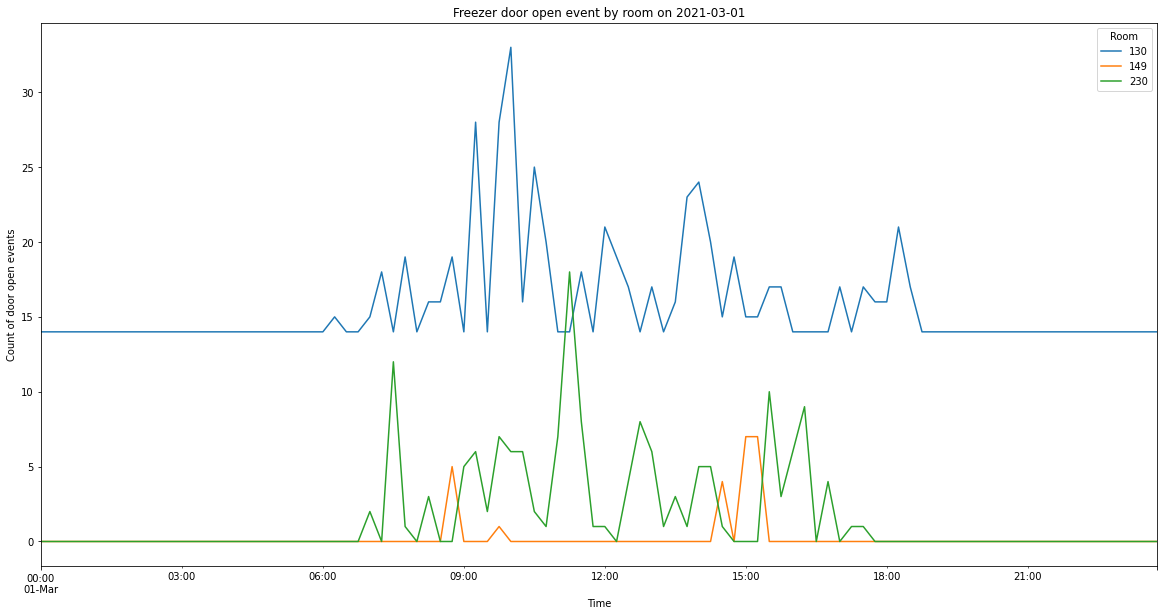

In [ ]:
freezers['2021-03-01'].groupby(by="Room", axis=1).count().resample('15min').sum().plot()
plt.title('Freezer door open event by room on 2021-03-01')
plt.xlabel('Time')
plt.ylabel('Count of door open events')

# Occupancy sensors - individual

## Processing the CSV files to pickles

In [ ]:
# Cheat on reading the number of header rows -> do it manually
for f in os.listdir(drive_path + '/occSensors'):
    print(f)

lightingFloor1_occSensors1.csv
lightingFloor1_occSensors2.csv
lightingFloor2_occSensors1.csv
lightingFloor2_occSensors2.csv
lightingFloor3_occSensors.csv
lightingFloor4_occSensors.csv
lightingFloor1_2.pkl
.ipynb_checkpoints
lightingFloor3.pkl
lightingFloor4.pkl
lightingFloor1_1.pkl
lightingFloor1.pkl
lightingFloor2_1.pkl
lightingFloor2.pkl
lightingFloor1.csv
lightingFloor2.csv
lightingFloor2_2.pkl
lightingFloor3.csv
lightingFloor4.csv


In [ ]:
# Combine occ sensor files
# occSensor_df = pd.DataFrame()

def readOccSensorFile(f, skip):
    # print(f)
    # Need to figure out how many rows to skip... or skip to [DATA] section of the file
    new_df = pd.read_csv(drive_path + '/occSensors/' + f, na_values="Missing data", skiprows=skip)

    # Shift column labels right
    new_labels = []
    for i in range(0,new_df.columns.size-1,2):
      new_labels.append('ts_'+new_df.columns[i])
      new_labels.append(new_df.columns[i])
    new_labels.append('to_delete')
    new_df.columns = new_labels

    # Parse columns, every two columns is an index,val pair
    new_df_list = []
    for i in range(0,new_df.columns.size-1,2):
      cols = new_df.columns[i:i+2]
      new_mini_df = new_df.drop(0)[cols]
      new_mini_df.index = pd.DatetimeIndex(
            pd.to_datetime(new_mini_df[cols[0]], utc=True))
      new_mini_df.index.name='ts'
      new_mini_df = new_mini_df.dropna(how='all').drop(columns=cols[0])
      new_df_list.append(new_mini_df)

    return new_df_list


#     if occSensor_df.empty:
#         occSensor_df = occ_df
#     else:
#         occSensor_df = occSensor_df.merge(occ_df, how='outer', on="ts", sort=True)
  
# occ = occSensor_df.copy()


def merge_df_lists(new_df_list):
  occ_df = pd.DataFrame()
  for df in new_df_list:
        if occ_df.empty:
            occ_df = df
        else:
            occ_df = occ_df.merge(df, how='outer', on="ts", sort=True)
  return occ_df

In [ ]:
# lightingFloor1_occSensors1 = readOccSensorFile("lightingFloor1_occSensors1.csv", 86)
# lightingFloor1_1= merge_df_lists(lightingFloor1_occSensors1)
# lightingFloor1_1.to_pickle(drive_path + '/occSensors/' + "lightingFloor1_1.pkl")

In [ ]:
# lightingFloor1_occSensors2 = readOccSensorFile("lightingFloor1_occSensors2.csv",86)
# lightingFloor1_2= merge_df_lists(lightingFloor1_occSensors2)
# lightingFloor1_2 = pd.read_pickle(drive_path + '/occSensors/' + "lightingFloor1_2.pkl")

In [ ]:
# lightingFloor2_occSensors1 = readOccSensorFile("lightingFloor2_occSensors1.csv",93)
# lightingFloor2_1= merge_df_lists(lightingFloor2_occSensors1)
# lightingFloor2_1.to_pickle(drive_path + '/occSensors/' + "lightingFloor2_1.pkl")

In [ ]:
# lightingFloor2_occSensors2 = readOccSensorFile("lightingFloor2_occSensors2.csv",93)

In [ ]:
# lightingFloor2_2= merge_df_lists(lightingFloor2_occSensors2)
# lightingFloor2_2.to_pickle(drive_path + '/occSensors/' + "lightingFloor2_2.pkl")

In [ ]:
# lightingFloor3_occSensors = readOccSensorFile("lightingFloor3_occSensors.csv",71)
# lightingFloor3= merge_df_lists(lightingFloor3_occSensors)
# lightingFloor3.to_pickle(drive_path + '/occSensors/' + "lightingFloor3.pkl")

In [ ]:
# lightingFloor4_occSensors = readOccSensorFile("lightingFloor4_occSensors.csv",85)
# lightingFloor4= merge_df_lists(lightingFloor4_occSensors)
# lightingFloor4.to_pickle(drive_path + '/occSensors/' + "lightingFloor4.pkl")

## Processing the pickles

In [ ]:
# lightingFloor1_1 = pd.read_pickle(drive_path + '/occSensors/' + "lightingFloor1_1.pkl")
# lightingFloor1_2 = pd.read_pickle(drive_path + '/occSensors/' + "lightingFloor1_2.pkl")

# lightingFloor1 = lightingFloor1_1.append(lightingFloor1_2[lightingFloor1_1.index[-1]:])
# lightingFloor1.to_pickle(drive_path + '/occSensors/' + "lightingFloor1.pkl")

In [ ]:
# lightingFloor2_1 = pd.read_pickle(drive_path + '/occSensors/' + "lightingFloor2_1.pkl")
# lightingFloor2_2 = pd.read_pickle(drive_path + '/occSensors/' + "lightingFloor2_2.pkl")

# lightingFloor2 = lightingFloor2_1.append(lightingFloor2_2[lightingFloor2_1.index[-1]:])
# lightingFloor2.to_pickle(drive_path + '/occSensors/' + "lightingFloor2.pkl")

In [ ]:
# lightingFloor1 = pd.read_pickle(drive_path + '/occSensors/' + "lightingFloor1.pkl")
# lightingFloor2 = pd.read_pickle(drive_path + '/occSensors/' + "lightingFloor2.pkl")
# lightingFloor3 = pd.read_pickle(drive_path + '/occSensors/' + "lightingFloor3.pkl")
# lightingFloor4 = pd.read_pickle(drive_path + '/occSensors/' + "lightingFloor4.pkl")

In [ ]:
# lightingFloor1.to_csv(drive_path + '/occSensors/' + "lightingFloor1.csv")
# lightingFloor2.to_csv(drive_path + '/occSensors/' + "lightingFloor2.csv")
# lightingFloor3.to_csv(drive_path + '/occSensors/' + "lightingFloor3.csv")
# lightingFloor4.to_csv(drive_path + '/occSensors/' + "lightingFloor4.csv")

In [ ]:
# lightingFloor1 = pd.read_csv(drive_path + '/occSensors/' + "lightingFloor1.csv", index_col=0, dtype="str", parse_dates=True)
# lightingFloor2 = pd.read_csv(drive_path + '/occSensors/' + "lightingFloor2.csv", index_col=0, dtype="str", parse_dates=True)
# lightingFloor3 = pd.read_csv(drive_path + '/occSensors/' + "lightingFloor3.csv", index_col=0, dtype="str", parse_dates=True)
# lightingFloor4 = pd.read_csv(drive_path + '/occSensors/' + "lightingFloor4.csv", index_col=0, dtype="str", parse_dates=True)

In [ ]:
def replaceLightingValues(df):
  return df.replace("Occupied", 1).replace("Unoccupied", 0)

In [ ]:
# lightingFloor1 = pd.read_csv(drive_path + '/occSensors/' + "lightingFloor1.csv", index_col=0, dtype="str", parse_dates=True)
# lightingFloor1 = lightingFloor1.replace("Occupied", 1).replace("Unoccupied", 0).dropna(how='all').resample('5min').max()
# lightingFloor1.head()

In [ ]:
# lightingFloor2 = pd.read_csv(drive_path + '/occSensors/' + "lightingFloor2.csv", index_col=0, dtype="str", parse_dates=True)
# lightingFloor2 = lightingFloor2.replace("Occupied", 1).replace("Unoccupied", 0)
# lightingFloor2 = lightingFloor2.dropna(how='all').resample('5min').max()
# lightingFloor2.head()

In [ ]:
# lightingFloor3 = pd.read_csv(drive_path + '/occSensors/' + "lightingFloor3.csv", index_col=0, dtype="str", parse_dates=True)
# lightingFloor3 = lightingFloor3.replace("Occupied", 1).replace("Unoccupied", 0).dropna(how='all').resample('5min').max()
# lightingFloor3.head()

In [ ]:
# lightingFloor4 = pd.read_csv(drive_path + '/occSensors/' + "lightingFloor4.csv", index_col=0, dtype="str", parse_dates=True)
# lightingFloor4 = lightingFloor4.replace("Occupied", 1).replace("Unoccupied", 0).dropna(how='all').resample('5min').max()
# lightingFloor4.head()

In [ ]:
# lighting = lightingFloor1.merge(lightingFloor2, how='outer', on='ts') \
#   .merge(lightingFloor3, how='outer', on='ts') \
#   .merge(lightingFloor4, how='outer', on='ts')

In [ ]:
# lighting.to_csv(drive_path + "/lighting.csv")

## Labeling occ sensor data

In [ ]:
lighting = pd.read_csv(drive_path + "/lighting.csv", index_col=0, parse_dates=True)
# lighting.head()

In [ ]:
def reindexLighting(df):
  # Re-index with Floor / Room / Rooms metadata
  arrays = [
            df.columns.str.extract(r'^(\d)').to_numpy().transpose()[0],
            df.columns.str.extract(r'^(\w{3}[a-d|f-m]?)').to_numpy().transpose()[0],
            df.columns.str.extract(r'\[(.*)\]$').to_numpy().transpose()[0],
            df.columns
  ]
  # arrays[0][0] = arrays[0][1]
  # arrays[1][0] = "All"
  # arrays[2][0] = "Summary"
  df.columns = pd.MultiIndex.from_arrays(arrays, names=['Floor','Room','Sensor','Tag'])
  
reindexLighting(lighting)

In [ ]:
lighting.head()
# lighting.to_csv(drive_path + "cleaned/lightingOccSensors.csv")
lighting.to_pickle(drive_path + "cleaned/lightingOccSensors.pkl")

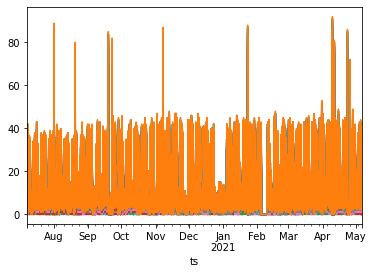

In [ ]:
lighting.groupby(by="Room", axis=1).max().plot(stacked=True, legend=False)

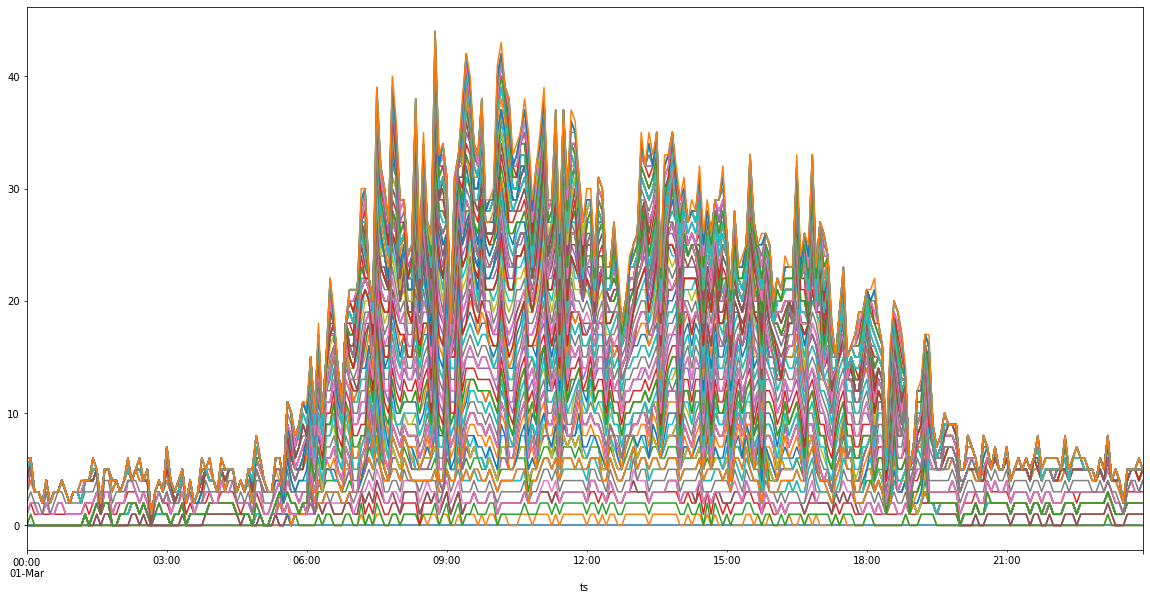

In [ ]:
lighting["2021-03-01"].groupby(by="Room", axis=1).max().plot(stacked=True, legend=False)

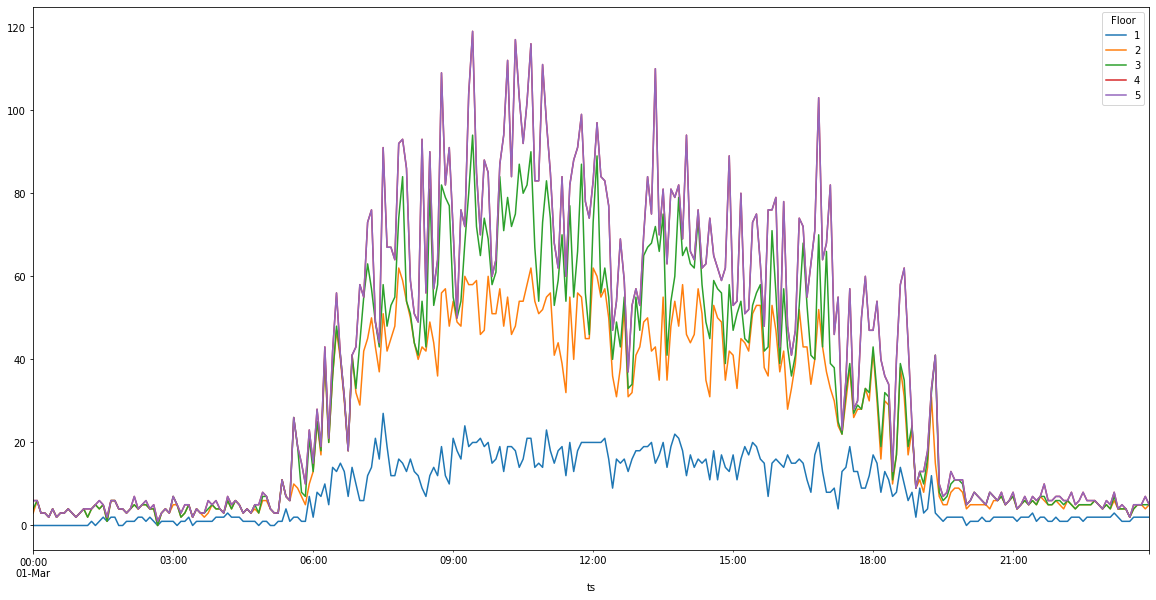

In [ ]:
lighting["2021-03-01"].groupby(by="Floor", axis=1).sum().plot(stacked=True, legend=True)

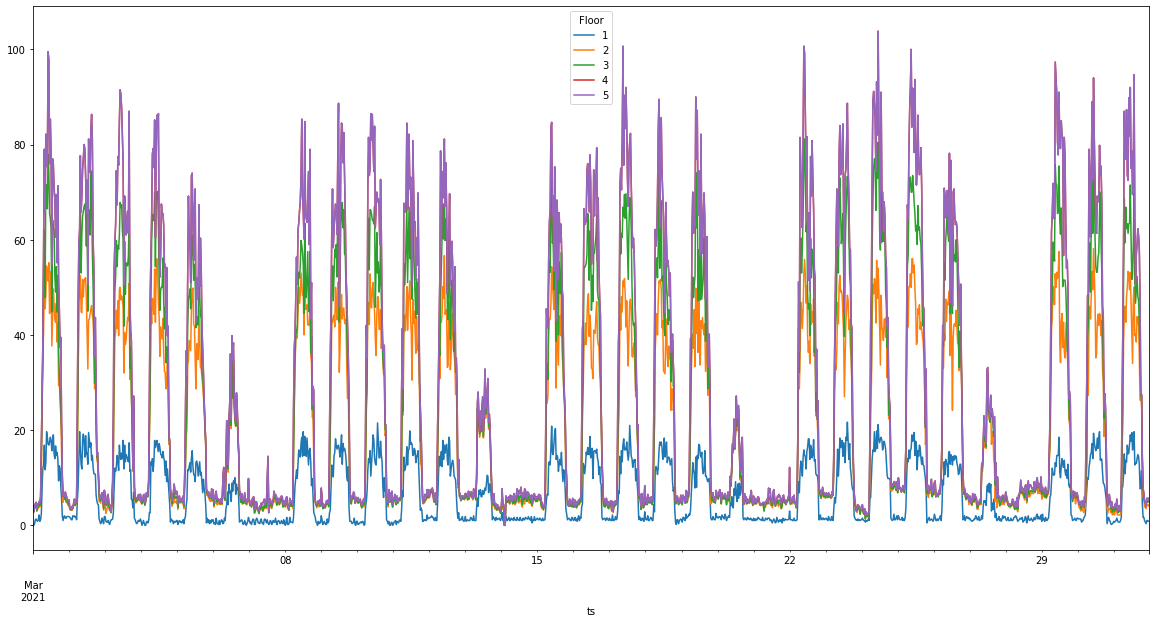

In [ ]:
lighting["2021-03"].groupby(by="Floor", axis=1).sum().resample('30min').mean().plot(stacked=True, legend=True)